## 套件匯入

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import networkx as nx
import tensorflow as tf
import pandas as pd
import pickle
import re
import string
import zhon
import nltk
from docx import Document
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
from tensorflow.python.util import deprecation
from zhon.hanzi import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 讀取檔案

In [2]:
f = open('C:/Users/sefx5/Downloads/議程附件4-總綱小組第1-7次諮詢會議紀錄(稿).docx','rb')
document = Document(f)

## 匯入字典

In [ ]:
# 只需執行一次
# data_utils.download_data("./")

In [3]:
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

## 截取會議内容與參與會議人員（本院 / 非本院）

In [4]:
sentence_list,ppl_list,save_content = [],[],False
for para in document.paragraphs:
    if save_content:
        if para.text != '' or para.text != '\n':
            sentence_list.append(para.text)
    if para.text[:4] in ['出席人員','請假人員']:
        ppl_list.append(para.text[5:])
    if para.text == '發言紀要：':
        save_content = True
    if para.text[:5] == '決  議：':
        save_content = False

In [5]:
# 將人員列表分爲：
## 1.全體人員 -> final_ppl
## 2.本院人員 -> final_in_ppl
## 3.非本院人員 -> final_out_ppl

in_ppl,out_ppl = [],[]
for each in ppl_list:
    for ppl_ in each.split('、'):
        if ppl_[:2] == '本院' or ppl_[-3:] == '研究員' or ppl_[-2:] == '助理':
            in_ppl.append(ppl_)
        else:
            out_ppl.append(ppl_)

In [6]:
# 確保人員名單為唯一值
in_ppl = list({each : 1 for each in in_ppl}.keys())
out_ppl = list({each : 1 for each in out_ppl}.keys())

In [7]:
in_pos = pos(in_ppl)
in_ner = ner(in_ppl,in_pos)
print(in_ppl)

['本院課程及教學研究中心李文富主任', '楊秀菁助理研究員', '張文龍助理研究員', '本院課程及教學研究中心林燕玲助理研究員', '財團法人公共電視文化事業基金會徐青雲研發部研究員', '本院洪詠善副研究員', '林燕玲助理研究員', '本院課程及教學研究中心洪詠善副研究員', '熊心沂行政助理']


In [ ]:
final_in_ppl = []
for no,each_ppl in enumerate(in_ner):
    if len(each_ppl) == 0:
        final_in_ppl.append(input(in_ppl[no]+':'))
    else: final_in_ppl.append(list(each_ppl)[0][3])
final_in_ppl = list(set(final_in_ppl))

In [ ]:
out_pos = pos(out_ppl)
out_ner = ner(out_ppl,out_pos)
print(out_ppl)

In [ ]:
final_out_ppl = []
for no,each_ppl in enumerate(out_ner):
    final_out_ppl.append(input(out_ppl[no]+':'))
final_out_ppl = list(set(final_out_ppl))

In [ ]:
final_ppl = final_in_ppl+final_out_ppl

## 暫存 Pickle 檔

In [ ]:
# 輸出名單
outfile = open('attendance_list.pkl','wb')
pickle.dump([final_in_ppl,final_out_ppl,final_ppl],outfile)
outfile.close()
print('完成儲存')

In [8]:
# 輸入名單
infile = open('attendance_list.pkl','rb')
new_dict = pickle.load(infile)
final_in_ppl,final_out_ppl,final_ppl = new_dict[0],new_dict[1],new_dict[2]
print('完成寫入')

完成寫入


## 觀察資料與剖析

In [9]:
#过滤中英文标点符号、字母、数字
def filter_punc(desstr:list,restr=''):
    pattern = re.compile("[%s]+" % string.punctuation + "|[%s]+" % zhon.hanzi.punctuation + "|[%s]+" % 'a-zA-Z0-9') #匹配中英文符号及字母数字
    filter_ = [pattern.sub(restr,each_sentence) for each_sentence in desstr]
    return filter_

In [10]:
# 清整中英文标点符号、字母、数字
filter_ = filter_punc(sentence_list)

In [11]:
# 完成斷詞
ws_ = ws(filter_)
print(ws_,end = '')

[['一', '社團', '法人', '臺中市', '聽障', '生活', '無', '障礙', '發展', '協會', '潘信宏', '執行長'], ['    ', '一', '議程', '第', '頁', '臺灣', '手語', '的', '部分', '啟', '聰', '學校', '有', '溝通', '訓練', '是否', '可', '取代', '臺灣', '手語', '的', '學習', '啟', '聰', '學校', '是否', '也', '按', '固定', '課程', '來', '安排', '臺灣', '手語', '啟', '聰', '學校', '的', '溝通', '訓練', '以', '口手語', '為主', '而', '非', '自然', '手語', '即', '臺灣', '手語', '溝通', '訓練', '是', '以', '手勢', '來', '教', '中文', ' '], ['    ', '二', '臺灣', '目前', '的', '教育', '體系', '沒有', '在', '教', '臺灣', '手語', '啟', '聰', '學校', '也', '沒有', '以', '實際', '經驗', '為', '例啟', '聰', '學校', '畢業生', '工作', '發現', '他們', '以為', '用來', '溝通', '的', '文字', '手語', '就', '是', '臺灣', '手語', '語言', '已經', '快要', '消失', '了', '年輕人', '也', '不會', '臺灣', '手語', '因此', '建議', '啟', '聰', '學校', '的', '溝通', '訓練', '不能', '取代', '臺灣', '手語', '的', '學習'], ['二', '社團', '法人', '臺中市', '聽障', '生活', '無', '障礙', '發展', '協會', '潘信宏', '執行長', '啟', '聰', '學校', '也', '要', '有', '足夠', '的', '臺灣', '手語', '師資', '目前', '校', '內', '的', '老師', '們', '也', '以為', '自己', '教', '的', '就', '是', '臺灣', '手語'], ['三', '本', '院', 

In [12]:
# 將不同發言人的内容進行歸類
speech = {}
coll_perm = False
name = ''

for each_sentence in ws_:
    for each_word in each_sentence:
        if each_word in final_ppl:
            name = each_word
            speech[name] = []
            coll_perm = True
            break
        if coll_perm:
            speech[name].append(each_word)

In [13]:
# 裝歡 Data Frame 格式
df = pd.DataFrame({'name' : list(speech.keys()) , 'sentence' : list(speech.values()) })

In [14]:
df.head()

,name,sentence
0,潘信宏,"[ , 一, 臺灣, 手語, 非, 國際, 通用, 係, 視覺, 語言, 與, 一般,..."
1,楊秀菁,"[四十九, 本, 院, 課程, 及, 教學, 研究, 中心]"
2,吳律德,"[ , 三十九, 本, 院, 課程, 及, 教學, 研究, 中心]"
3,李川信,"[ , 四十一, 國立, 二林, 高級, 工商, 職業, 學校]"
4,李文富,"[ , 一, 原住民族, 語文, 課程, 校訂, 可, 於, 非正式, 課程, 實施,..."


In [15]:
# 截取及關鍵字計算，並轉成 DataFrame
keywords_collection = sum(list(df['sentence']), [])
each_words_count = nltk.FreqDist(keywords_collection)
df_label_keyword = pd.DataFrame.from_dict(each_words_count, orient='index',columns = ['count']).sort_values(['count'], ascending = False).reset_index().rename(columns = {'index' : 'keyword'})

In [16]:
# 建立贅詞列表，作爲刪去無意義字眼
rubbish_keyword = ['之','的','    ','一','二','三','四','五','六','七','八','九','十','第','本','頁','各','與','及','院','在','應','國家','有','於','學生','新']

In [17]:
# 去除 rubbish keyword Data Frame
df_label_keyword = df_label_keyword[~df_label_keyword['keyword'].isin(rubbish_keyword)].reset_index(drop = True)

In [92]:
df_label_keyword

,keyword,count
0,課程,237
1,語文,147
2,語言,102
3,本土,68
4,手語,68
5,臺灣,64
6,建議,58
7,學校,57
8,教育,54
9,說明,48


In [19]:
# 建立一個關鍵字計算器，並導入到 df['sentence_matrix'] 中
def keyword_classification(list_):
    output = []
    for keyword in list(df_label_keyword['keyword']):
        if keyword in list_:
            count = 0
            for word in list_:
                if word == keyword:
                    count+=1
            output.append(count)
            continue
        output.append(0)
    return output
                      
df['sentence_matrix'] = df['sentence'].apply(keyword_classification)

In [20]:
df_cooc_matrix = pd.DataFrame(list(df['sentence_matrix']),columns = list(df_label_keyword['keyword'])).reset_index(drop = True)
df_cooc_matrix.head()

,課程,語文,語言,本土,手語,臺灣,建議,學校,教育,說明,...,足以,支應,下限,大學端,不一定,達到,附則,收穫,涉及,位階
0,0,0,7,0,7,5,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_cooc_matrix = df_cooc_matrix.iloc[:,:20]

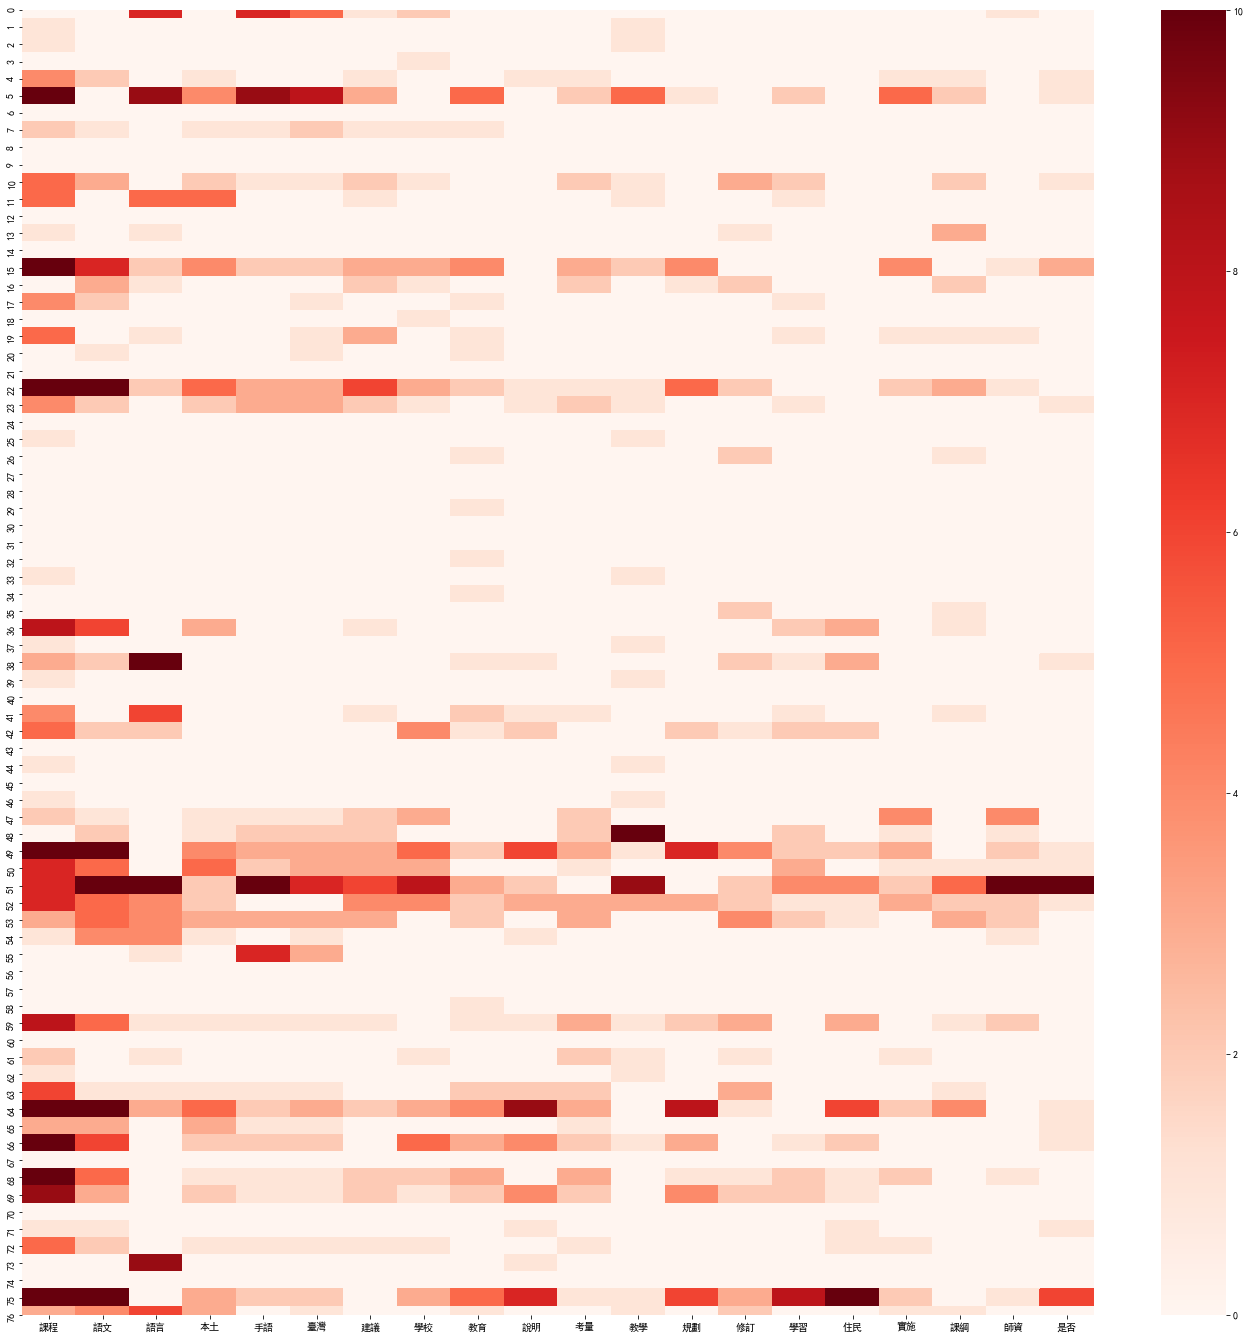

In [22]:
# 畫熱點圖驗證關鍵字的分佈情況
plt.figure(figsize=(24,24))
sn.heatmap(df_cooc_matrix,vmin = 0,vmax = 10,cmap='Reds')
plt.show()

## 共現性矩陣

In [35]:
# 計算共現性矩陣（轉置矩陣，矩陣相乘）
co_mtx = df_cooc_matrix.T.dot(df_cooc_matrix)
co_mtx
# co_mtx = df_cooc_matrix.corr()
# co_mtx

,課程,語文,語言,本土,手語,臺灣,建議,學校,教育,說明,考量,教學,規劃,修訂,學習,住民,實施,課綱,師資,是否
課程,2431,1404,516,585,485,471,418,519,518,547,370,271,588,300,416,493,325,223,244,359
語文,1404,1195,466,406,370,333,336,412,308,401,242,226,430,252,274,358,217,199,309,338
語言,516,466,968,182,431,308,235,237,185,121,74,274,70,119,144,151,127,186,364,340
本土,585,406,182,226,155,156,150,133,125,128,108,89,154,83,98,101,101,84,74,88
手語,485,370,431,155,392,286,179,180,140,95,85,192,94,74,115,99,111,110,217,209
臺灣,471,333,308,156,286,234,153,143,129,95,87,143,101,67,98,85,101,90,143,140
建議,418,336,235,150,179,153,182,143,102,79,96,122,108,77,80,60,98,97,140,113
學校,519,412,237,133,180,143,143,217,115,142,87,109,146,76,101,116,94,76,166,161
教育,518,308,185,125,140,129,102,115,150,127,87,80,137,72,92,113,89,65,74,101
說明,547,401,121,128,95,95,79,142,127,228,89,47,204,87,98,170,66,60,59,96


## 資料正則化

In [36]:
co_mtx_probability = np.floor_divide(co_mtx,df_label_keyword['count'].iloc[:20])
co_mtx_probability

,課程,語文,語言,本土,手語,臺灣,建議,學校,教育,說明,考量,教學,規劃,修訂,學習,住民,實施,課綱,師資,是否
課程,10,9,5,8,7,7,7,9,9,11,7,5,12,6,10,12,9,6,6,10
語文,5,8,4,5,5,5,5,7,5,8,5,4,9,5,6,8,6,5,8,9
語言,2,3,9,2,6,4,4,4,3,2,1,5,1,2,3,3,3,5,10,9
本土,2,2,1,3,2,2,2,2,2,2,2,1,3,1,2,2,2,2,2,2
手語,2,2,4,2,5,4,3,3,2,1,1,4,2,1,2,2,3,3,6,5
臺灣,1,2,3,2,4,3,2,2,2,1,1,2,2,1,2,2,2,2,3,4
建議,1,2,2,2,2,2,3,2,1,1,2,2,2,1,1,1,2,2,3,3
學校,2,2,2,1,2,2,2,3,2,2,1,2,3,1,2,2,2,2,4,4
教育,2,2,1,1,2,2,1,2,2,2,1,1,2,1,2,2,2,1,2,2
說明,2,2,1,1,1,1,1,2,2,4,1,0,4,2,2,4,1,1,1,2


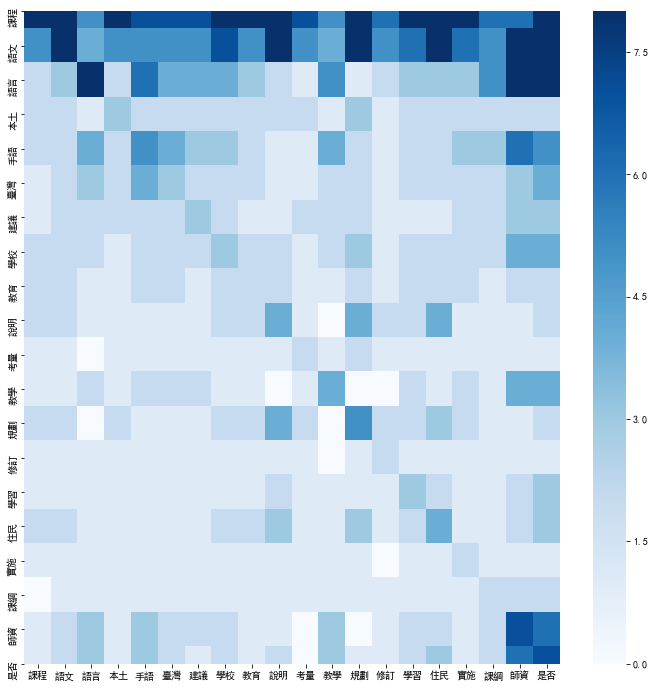

In [42]:
plt.figure(figsize=(12,12))
sn.heatmap(co_mtx_probability,vmin = 0,vmax = 8,cmap='Blues')
plt.show()

## 視覺化網絡圖

In [27]:
# 將内容轉換成 Graph 接受的形式
high_cor_list = []
for col_index in co_mtx.columns:
    for row_index in co_mtx.columns:
        if co_mtx[col_index][row_index] > 0:
            high_cor_list.append((col_index,row_index,co_mtx.loc[col_index][row_index]))

In [28]:
# 初始化無向圖，並將關鍵字與權重新增到 Graph 中
G = nx.Graph()
G.add_weighted_edges_from(high_cor_list)

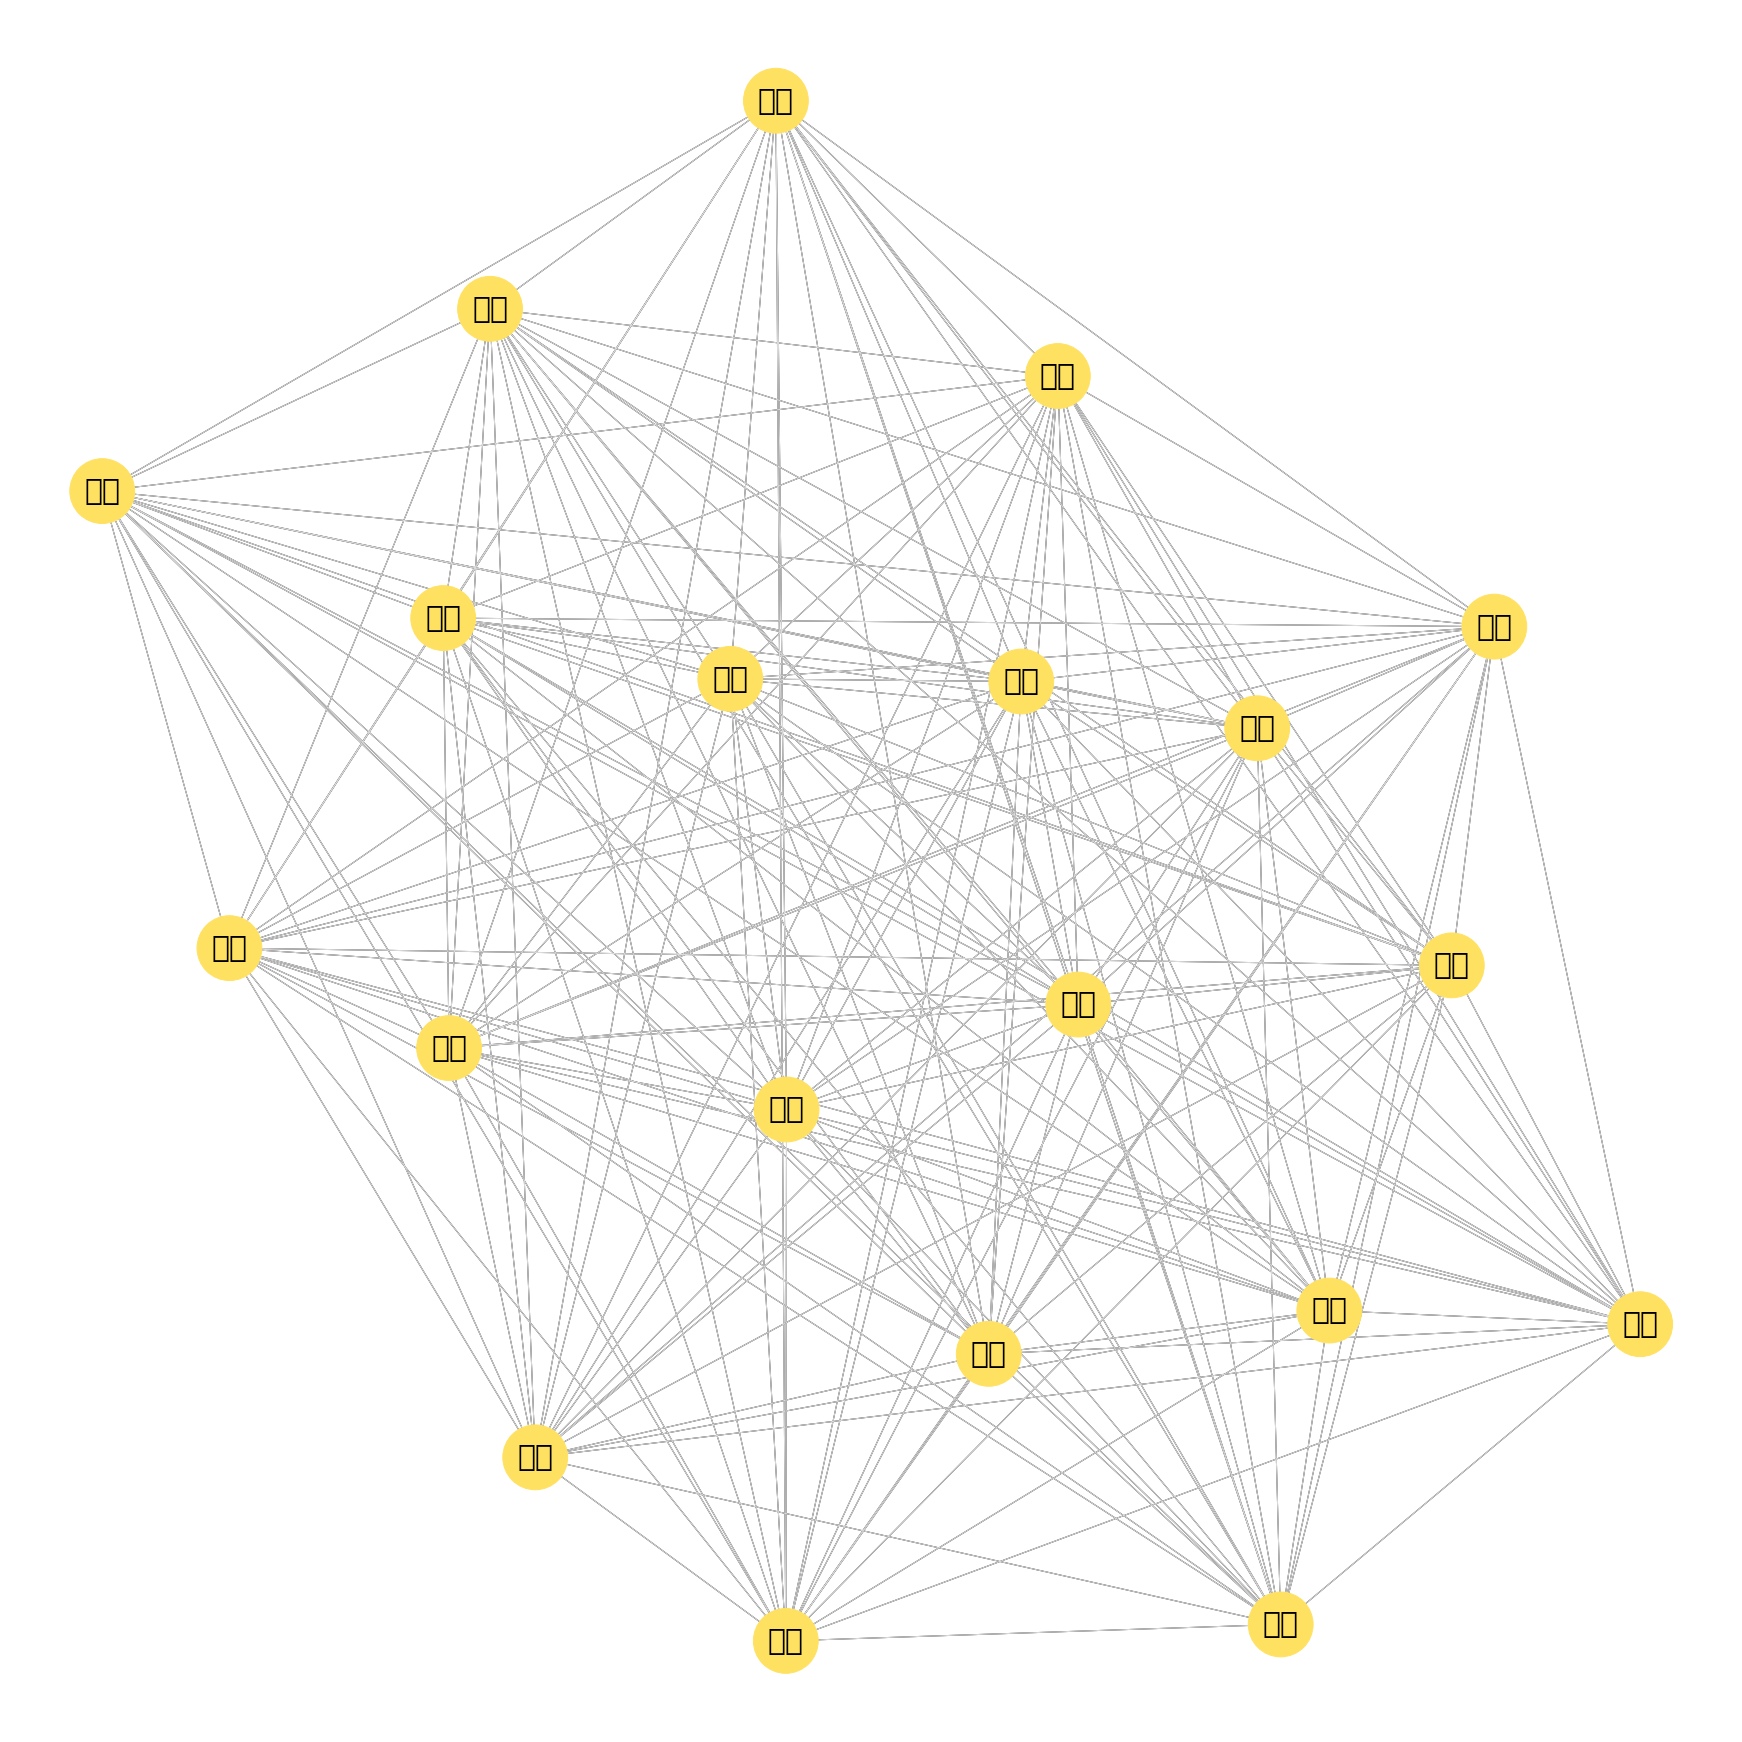

In [34]:
# 繪製關鍵字之網路圖
plt.figure(figsize=(24,24))
pos = nx.spring_layout(G)
nx.draw(G,pos,node_size = [val*200 for (node, val) in G.degree()],node_color = '#FFE162')
nx.draw_networkx_labels(G, pos, font_size = 30,alpha = 1)
nx.draw_networkx_edges(G, pos, edge_color = '#DDDDDD', alpha = 1,with_labels=True)
plt.show()

## 本院 vs 非本院

In [52]:
df_in = df[~df['name'].isin(final_out_ppl)].reset_index(drop = True)
print('本院人員總數：' + str(df_in.shape[0]))
df_in

本院人員總數：4


,name,sentence,sentence_matrix
0,楊秀菁,"[四十九, 本, 院, 課程, 及, 教學, 研究, 中心]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,李文富,"[ , 一, 原住民族, 語文, 課程, 校訂, 可, 於, 非正式, 課程, 實施,...","[4, 2, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,張文龍,"[二十一, 基隆市, 政府, 教育處, 江忠僑, 課程, 督學, 修訂, 課綱, 應, 依據...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,林燕玲,"[ , 一, 手勢, 中文, 需, 有, 中文, 概念, 方, 能, 做, 手勢, 的...","[0, 0, 1, 0, 7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [88]:
df_cooc_matrix_in = pd.DataFrame(list(df_in['sentence_matrix']),columns = list(df_label_keyword['keyword'])).reset_index(drop = True)
df_cooc_matrix_in.head()

,課程,語文,語言,本土,手語,臺灣,建議,學校,教育,說明,...,足以,支應,下限,大學端,不一定,達到,附則,收穫,涉及,位階
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,2,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,7,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


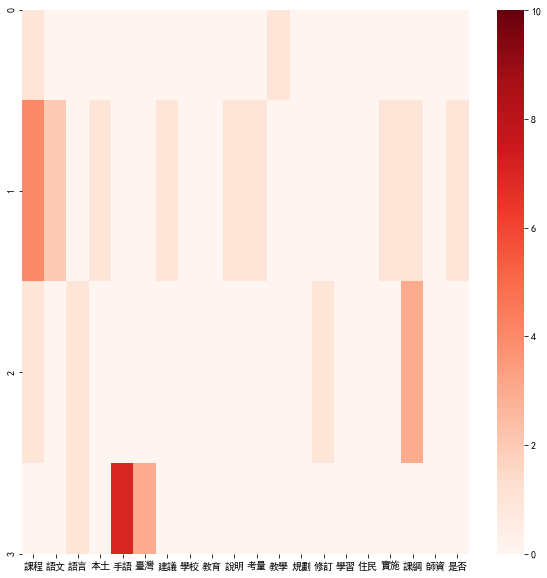

In [89]:
# 畫熱點圖驗證關鍵字的分佈情況
df_cooc_matrix_in = df_cooc_matrix_in.iloc[:,:20]
plt.figure(figsize=(10,10))
sn.heatmap(df_cooc_matrix_in,vmin = 0,vmax = 10,cmap='Reds')
plt.show()

In [90]:
# 計算共現性矩陣（轉置矩陣，矩陣相乘）
co_mtx_in = df_cooc_matrix_in.T.dot(df_cooc_matrix_in)
co_mtx_in

,課程,語文,語言,本土,手語,臺灣,建議,學校,教育,說明,考量,教學,規劃,修訂,學習,住民,實施,課綱,師資,是否
課程,18,8,1,4,0,0,4,0,0,4,4,1,0,1,0,0,4,7,0,4
語文,8,4,0,2,0,0,2,0,0,2,2,0,0,0,0,0,2,2,0,2
語言,1,0,2,0,7,3,0,0,0,0,0,0,0,1,0,0,0,3,0,0
本土,4,2,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,1
手語,0,0,7,0,49,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0
臺灣,0,0,3,0,21,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0
建議,4,2,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,1
學校,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
教育,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
說明,4,2,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,1


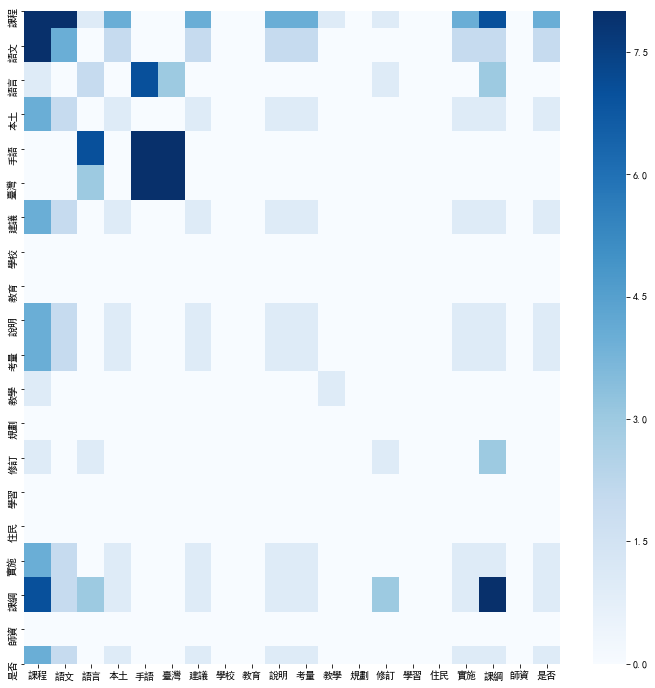

In [76]:
plt.figure(figsize=(12,12))
sn.heatmap(co_mtx_in,vmin = 0,vmax = 8,cmap='Blues')
plt.show()

In [53]:
df_out = df[~df['name'].isin(final_in_ppl)].reset_index(drop = True)
print('非本院人員總數：' + str(df_out.shape[0]))
df_out.head()

非本院人員總數：73


,name,sentence,sentence_matrix
0,潘信宏,"[ , 一, 臺灣, 手語, 非, 國際, 通用, 係, 視覺, 語言, 與, 一般,...","[0, 0, 7, 0, 7, 5, 1, 2, 0, 0, 0, 0, 0, 0, 0, ..."
1,吳律德,"[ , 三十九, 本, 院, 課程, 及, 教學, 研究, 中心]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,李川信,"[ , 四十一, 國立, 二林, 高級, 工商, 職業, 學校]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,廖浩翔,"[ , 一十二, 年, 國民, 基本, 教育, 身心, 障礙, 相關, 之, 特殊, ...","[12, 0, 9, 4, 9, 8, 3, 0, 5, 0, 2, 5, 1, 0, 2,..."
4,謝國清,"[ , 四十四, 屏東, 縣立, 來義, 高級, 中學]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [58]:
df_cooc_matrix_out = pd.DataFrame(list(df_out['sentence_matrix']),columns = list(df_label_keyword['keyword'])).reset_index(drop = True)
df_cooc_matrix_out.head()

,課程,語文,語言,本土,手語,臺灣,建議,學校,教育,說明,...,足以,支應,下限,大學端,不一定,達到,附則,收穫,涉及,位階
0,0,0,7,0,7,5,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12,0,9,4,9,8,3,0,5,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


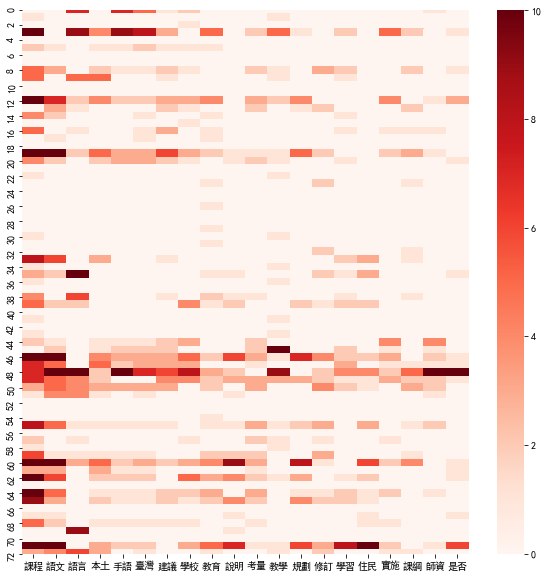

In [60]:
# 畫熱點圖驗證關鍵字的分佈情況
df_cooc_matrix_out = df_cooc_matrix_out.iloc[:,:20]
plt.figure(figsize=(10,10))
sn.heatmap(df_cooc_matrix_out,vmin = 0,vmax = 10,cmap='Reds')
plt.show()

In [63]:
# 計算共現性矩陣（轉置矩陣，矩陣相乘）
co_mtx = df_cooc_matrix_out.T.dot(df_cooc_matrix_out)
co_mtx

,課程,語文,語言,本土,手語,臺灣,建議,學校,教育,說明,考量,教學,規劃,修訂,學習,住民,實施,課綱,師資,是否
課程,2413,1396,515,581,485,471,414,519,518,543,366,270,588,299,416,493,321,216,244,355
語文,1396,1191,466,404,370,333,334,412,308,399,240,226,430,252,274,358,215,197,309,336
語言,515,466,966,182,424,305,235,237,185,121,74,274,70,118,144,151,127,183,364,340
本土,581,404,182,225,155,156,149,133,125,127,107,89,154,83,98,101,100,83,74,87
手語,485,370,424,155,343,265,179,180,140,95,85,192,94,74,115,99,111,110,217,209
臺灣,471,333,305,156,265,225,153,143,129,95,87,143,101,67,98,85,101,90,143,140
建議,414,334,235,149,179,153,181,143,102,78,95,122,108,77,80,60,97,96,140,112
學校,519,412,237,133,180,143,143,217,115,142,87,109,146,76,101,116,94,76,166,161
教育,518,308,185,125,140,129,102,115,150,127,87,80,137,72,92,113,89,65,74,101
說明,543,399,121,127,95,95,78,142,127,227,88,47,204,87,98,170,65,59,59,95


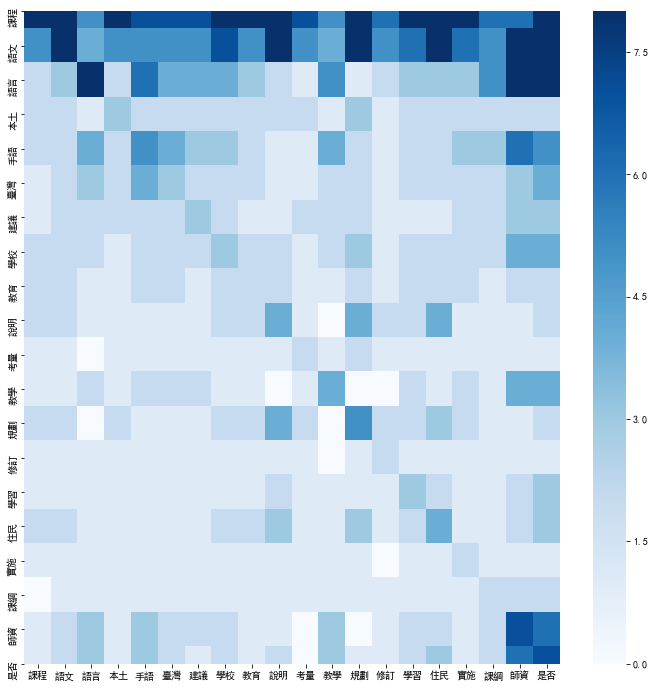

In [64]:
plt.figure(figsize=(12,12))
sn.heatmap(co_mtx_probability,vmin = 0,vmax = 8,cmap='Blues')
plt.show()

In [65]:
co_mtx_out = df_cooc_matrix_out.corr()
co_mtx_out

,課程,語文,語言,本土,手語,臺灣,建議,學校,教育,說明,考量,教學,規劃,修訂,學習,住民,實施,課綱,師資,是否
課程,1.000000,0.760429,0.168150,0.703600,0.416595,0.513779,0.487592,0.628671,0.806794,0.685386,0.597027,0.205655,0.748545,0.442311,0.665583,0.671523,0.558608,0.334452,0.201307,0.392550
語文,0.760429,1.000000,0.309023,0.705065,0.484574,0.534379,0.628876,0.757053,0.636778,0.725152,0.549954,0.306997,0.782941,0.612688,0.611064,0.697768,0.527540,0.530855,0.501613,0.581355
語言,0.168150,0.309023,1.000000,0.245047,0.691904,0.582993,0.466483,0.420248,0.367574,0.140190,0.037639,0.506329,0.013633,0.229358,0.290903,0.249718,0.299186,0.577808,0.693671,0.663145
本土,0.703600,0.705065,0.245047,1.000000,0.453122,0.592902,0.647195,0.480439,0.562367,0.467581,0.562839,0.249450,0.605923,0.379673,0.450205,0.375729,0.578425,0.501391,0.203301,0.283933
手語,0.416595,0.484574,0.691904,0.453122,1.000000,0.949399,0.658004,0.589782,0.529229,0.232488,0.301547,0.621569,0.223811,0.248639,0.450540,0.287223,0.521301,0.582455,0.694220,0.687658
臺灣,0.513779,0.534379,0.582993,0.592902,0.949399,1.000000,0.683679,0.550448,0.606077,0.301164,0.407708,0.546848,0.327008,0.264134,0.460743,0.291608,0.592691,0.573269,0.543265,0.550434
建議,0.487592,0.628876,0.466483,0.647195,0.658004,0.683679,1.000000,0.641896,0.488202,0.252036,0.562375,0.507795,0.426522,0.413244,0.391669,0.181614,0.649819,0.726646,0.607849,0.475948
學校,0.628671,0.757053,0.420248,0.480439,0.589782,0.550448,0.641896,1.000000,0.528632,0.571613,0.431615,0.382868,0.581619,0.359285,0.500881,0.484822,0.553155,0.464341,0.666356,0.666154
教育,0.806794,0.636778,0.367574,0.562367,0.529229,0.606077,0.488202,0.528632,1.000000,0.626809,0.561103,0.299873,0.681059,0.426127,0.560578,0.597461,0.655519,0.470960,0.286587,0.470479
說明,0.685386,0.725152,0.140190,0.467581,0.232488,0.301164,0.252036,0.571613,0.626809,1.000000,0.463908,0.083002,0.865669,0.466867,0.486790,0.776205,0.329904,0.327258,0.162092,0.339173


In [93]:
import plotly.express as px
fig = px.scatter(co_mtx_out, x="手語", y="師資",color=co_mtx_out.index)
fig.show()

In [86]:
fig = px.scatter(co_mtx_in, x="師資", y="手語",color=co_mtx_in.index)
fig.show()

In [91]:
fig = px.scatter(co_mtx_in, x="課程", y="課綱",color=co_mtx_in.index)
fig.show()